In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1. Introduction:
Les véhicules autonomes devraient être capables de rouler en toute autonomie, dans des conditions de trafic réel et sur une infrastructure non spécifique, sans l'intervention d'un conducteur. 
Leur bon fonctionnement dépendra fortement du niveau de sécurité des équipements, de la qualité des logiciels et la fiabilité des informations utilisées par l’intelligence embarquée.


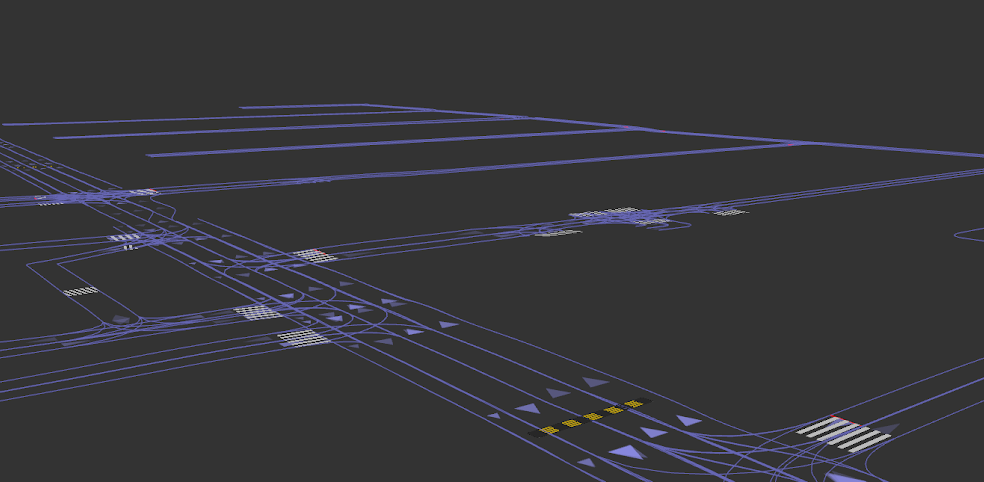

Cette image est une :"Semantic Maps for Autonomous Vehicles"

2. Installation de:
L5kit et 
pymap3d pour Python 3-D coordinate conversions 

In [ ]:
!pip install pymap3d==2.1.0
!pip install l5kit


3. Visualisation des trajectoires :

Les packages de base pour la visualisation sont:
Rasterization :
contient des classes pour obtenir des données visuelles sous forme de tenseurs multicanaux et les transformer en images RGB interprétables. Chaque classe a au moins une méthode rasterize pour obtenir le tenseur et une méthode to_rgb pour le convertir en image. Quelques exemples sont:

 BoxRasterizer: 
cet objet rend les agents (par exemple les véhicules ou les piétons) sous forme de boîtes 2D orientées
    SatelliteRasterizer: cet objet rend un recadrage orienté à partir d'une carte satellite.

Visualisation :

contient des utilitaires pour dessiner des informations supplémentaires (par exemple des trajectoires) sur des images RGB. Ces utilitaires sont couramment utilisés après un appel à to_rgb pour ajouter d'autres informations à la visualisation finale. Un exemple est:

   . draw_trajectory: cette fonction trace des trajectoires 2D à partir des coordonnées et du décalage de lacet sur une image


3. Chargement des packages:

In [ ]:
import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os


4. Configuration où résident nos données:

On s'attend à ce que les données vivent dans un dossier qui peut être configuré à l'aide de la variable d'environnement `L5KIT_DATA_FOLDER`. Mon dossier de données devrait contenir des sous-dossiers pour les cartes aériennes et sémantiques ainsi que les scènes (fichiers `.zarr`).
Dans cet exemple, la variable env est définie sur le dossier de données local. Je dois m’assurer que le chemin pointe vers le bon emplacement .

Le code est construit  pour qu'il fonctionne avec une configuration `yaml` lisible par l'homme. Ce fichier de configuration contient beaucoup d'informations utiles, cependant, nous nous concentrerons uniquement sur quelques fonctionnalités concernant le chargement et la visualisation ici.




In [ ]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"
# get config
cfg = load_config_data("/kaggle/input/lyftconfigfiles/visualisation_config.yaml")
print(cfg)

5. Analyse de la configuration actuelle pour des champs intéressants :

 lorsqu'il est chargé en python, le fichier yaml est converti en un dict python.

raster_params contient toutes les informations relatives à la transformation du monde 3D en plan image:

    . raster_size: la taille du plan image
    . pixel_size: combien de mètres correspondent à un pixel
    . ego_center: notre raster est centré autour d'un agent, nous pouvons déplacer l'agent dans le plan image avec ce paramètre
    . map_type: le rastériseur à utiliser. Nous prenons actuellement en charge un satellite et un sémantique. Nous examinerons les différences plus loin dans ce script



In [ ]:
print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")

6. Chargement des données:

Le même fichier de configuration est également utilisé pour charger les données. Chaque division des données a sa propre section et plusieurs ensembles de données peuvent être utilisés (dans leur ensemble ou en tranches). Dans ce court exemple, nous n'utiliserons que le premier ensemble de données de l'ensemble d'échantillons. Vous pouvez changer cela en configurant la variable 'train_data_loader' dans le fichier config.

Vous avez peut-être également remarqué que nous construisons un objet LocalDataManager. Cela résoudra les chemins relatifs de la configuration en utilisant la variable d'environnement L5KIT_DATA_FOLDER que nous venons de définir.


In [ ]:
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

7. Travailler avec les données brutes

Les fichiers .zarr prennent en charge la plupart des opérations de tableau numpy traditionnelles. Dans la cellule suivante, nous parcourons les images pour obtenir un nuage de points des emplacements AV


In [ ]:
frames = zarr_dataset.frames
coords = np.zeros((len(frames), 2))
for idx_coord, idx_data in enumerate(tqdm(range(len(frames)), desc="getting centroid to plot trajectory")):
    frame = zarr_dataset.frames[idx_data]
    coords[idx_coord] = frame["ego_translation"][:2]


plt.scatter(coords[:, 0], coords[:, 1], marker='.')
axes = plt.gca()
axes.set_xlim([-2500, 1600])
axes.set_ylim([-2500, 1600])

8. Autre distribution plus facile des types d'agents.

Nous pouvons obtenir tous les agents label_probabilities et obtenir l'argmax pour chaque raw. parce que les fichiers .zarr correspondent à un tableau numpy, nous pouvons utiliser toutes les opérations et fonctions numpy traditionnelles.


In [ ]:
agents = zarr_dataset.agents
probabilities = agents["label_probabilities"]
labels_indexes = np.argmax(probabilities, axis=1)
counts = []
for idx_label, label in enumerate(PERCEPTION_LABELS):
    counts.append(np.sum(labels_indexes == idx_label))
    
table = PrettyTable(field_names=["label", "counts"])
for count, label in zip(counts, PERCEPTION_LABELS):
    table.add_row([label, count])
print(table)

9. Travailler avec l'abstraction de données:

Même s'il est absolument parfait de travailler avec les données brutes, nous fournissons également des classes qui abstraits l'accès aux données pour offrir un moyen plus simple de générer des entrées et des cibles.
Objets de base

En plus du rastériseur, notre boîte à outils contient d'autres classes que vous voudrez peut-être utiliser lors de la création de votre solution. Le package d'ensemble de données, par exemple, implémente déjà des ensembles de données prêts pour PyTorch, de sorte que vous pouvez démarrer et commencer à coder immédiatement.
Package de jeu de données

Nous utiliserons deux classes du package de données pour cet exemple. Les deux peuvent être itérés et renvoyer des images multicanaux du rastériseur avec les décalages de trajectoires futures et d'autres informations.

    EgoDataset: cet ensemble de données itère sur les annotations AV
    AgentDataset: cet ensemble de données itère sur les annotations d'autres agents

Les deux prennent en charge le multi-threading (via PyTorch DataLoader) OOB.

In [ ]:
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)

10 .Que faire sinous voullons visualiser le véhicule autonome (AV)?

Prenons un échantillon du jeu de données et utilisons notre rastériseur pour obtenir une image RGB que nous pouvons tracer.

Si nous voulons tracer la trajectoire de vérité terrain, nous pouvons convertir la target_position du jeu de données (déplacements en mètres en coordonnées mondiales) en coordonnées de pixels dans l'espace image, et appeler notre fonction utilitaire draw_trajectory (notez que vous pouvez utiliser cette fonction pour les trajectoires prévues , ainsi que).





In [ ]:
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

plt.imshow(im[::-1])
plt.show()

11. Et si nous voullons changer le rasterizer?

Nous pouvons le faire facilement en créant un nouveau rasterizer
 et un nouveau jeu de données pour celui-ci. Dans cet exemple, nous changeons la valeur en py_satellite qui rend les boîtes sur une image aérienne.



In [ ]:
cfg["raster_params"]["map_type"] = "py_satellite"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
data = dataset[50]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

plt.imshow(im[::-1])
plt.show()

12. Et si nous voullons visualiser un agent?

Heureux que vous ayez demandé! Nous pouvons simplement remplacer l'EgoDataset par un AgentDataset. Maintenant, nous itérons sur les agents et non plus sur l'AV, et le premier se trouve être la voiture de vitesse (vous verrez celle-ci beaucoup dans le jeu de données).



In [ ]:
dataset = AgentDataset(cfg, zarr_dataset, rast)
data = dataset[0]

im = data["image"].transpose(1, 2, 0)
im = dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

plt.imshow(im[::-1])
plt.show()

13. Origine et orientation du système:

À ce stade, vous avez peut-être remarqué que nous retournons l'image sur l'axe Y avant de la tracer.

Lors du passage de la 3D à la 2D, nous nous en tenons à un système de droite, où l'origine est dans le coin inférieur gauche avec des valeurs x positives allant à droite et des valeurs y positives remontant le plan de l'image. La caméra est orientée vers le bas de l'axe z négatif.

Cependant, opencv et pyplot placent l'origine dans le coin supérieur gauche avec x positif allant à droite et positif y descendant dans le plan image. La caméra est tournée vers le bas de l'axe z positif.

Le retournement effectué sur l'image résultante est à des fins de visualisation pour tenir compte de la différence entre les deux cadres de coordonnées.

De plus, toutes nos rotations sont dans le sens anti-horaire pour une valeur positive de l'angle.
À quoi ressemble une scène entière?

Il est facile de visualiser une scène individuelle à l'aide de notre boîte à outils. EgoDataset et AgentDataset fournissent deux méthodes pour obtenir des indices intéressants:

    get_frame_indices renvoie les indices pour une image donnée. Pour l'EgoDataset, cela correspond à une seule observation, alors que plus d'un index pourrait être disponible pour le AgentDataset, car cette trame donnée peut contenir plus d'un agent valide
    get_scene_indices renvoie les indices pour une scène donnée. Pour les deux ensembles de données, ceux-ci peuvent renvoyer plusieurs index

Dans cet exemple, nous visualisons la deuxième scène du point de vue de l'ego:

In [ ]:
from IPython.display import display, clear_output
import PIL
 
cfg["raster_params"]["map_type"] = "py_semantic"
rast = build_rasterizer(cfg, dm)
dataset = EgoDataset(cfg, zarr_dataset, rast)
scene_idx = 2
indexes = dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)
    clear_output(wait=True)
    display(PIL.Image.fromarray(im[::-1]))